In [34]:
import pandas as pd
import numpy as np
import os
from analysis import *
import glob
import string
import plotly.graph_objects as go

In [35]:
colors = ['#e6194B', '#3cb44b', '#ffe119','#f58231','#42d4f4',
          '#f032e6','#fabed4','#469990','#aaffc3','#000075','#e6194B','#9a6324','#dcbeff']
plotted_models = ['DPN','ReXNet', 'EseVoVNet', 'TNT', 'Inception', 'HRNet', 'MobileNet', 'VGG19', 'ResNet-RS', 
                 'DenseNet', 'DPN_Magface', 'DPN_Cosface', 'SMAC']

In [36]:
models = get_finished_models_Phase1B()

rank_files = glob.glob('Phase1B/**/*_rank_by_id_val.csv')
rank_files += glob.glob('timm_explore_few_epochs/**/*_rank_by_id_val.csv')
rank_files_Phase1 = [x for x in rank_files if any([m in x for m in models])]
kacc_files = glob.glob('**/**/*_kacc_val.csv')
metadata = pd.read_csv('val_identities_gender-expression_seed_222.csv')

epochs = ['epoch_'+str(i) for i in [19,39,59,79,99]]

acc_df, acc_disp_df, rank_df = analyze_rank_files(rank_files_Phase1, metadata, epochs=epochs)
_, acc_disp_ratio_df, rank_ratio_df = analyze_rank_files(rank_files_Phase1, metadata, ratio=True, epochs=epochs)
err_df, error_ratio_df, _ = analyze_rank_files(rank_files_Phase1, metadata, ratio=True, error=True, epochs=epochs)

In [38]:
df

,index,epoch,Error,Disparity,model
1450,coat_lite_small_MagFace_AdamW_0.001_cosine_ran...,99,0.472368,4.619565,coat_lite_small
1718,coat_lite_small_MagFace_AdamW_rank_by_id_val,99,0.546687,5.306050,coat_lite_small
1614,coat_lite_small_ArcFace_AdamW_0.001_cosine_ran...,99,0.539550,5.471582,coat_lite_small
1720,coat_lite_small_CosFace_SGD_rank_by_id_val,99,0.290466,6.061027,coat_lite_small
1746,coat_lite_small_CosFace_AdamW_rank_by_id_val,99,0.120482,5.292562,coat_lite_small
...,...,...,...,...,...
1560,xception65_MagFace_SGD_0.1_cosine_rank_by_id_val,99,0.339969,2.794657,xception65
1638,xception65_CosFace_SGD_rank_by_id_val,99,0.287520,4.281954,xception65
1632,xception65_MagFace_AdamW_0.001_cosine_rank_by_...,99,0.369827,3.367339,xception65
1672,xception65_CosFace_AdamW_rank_by_id_val,99,0.519251,7.155055,xception65


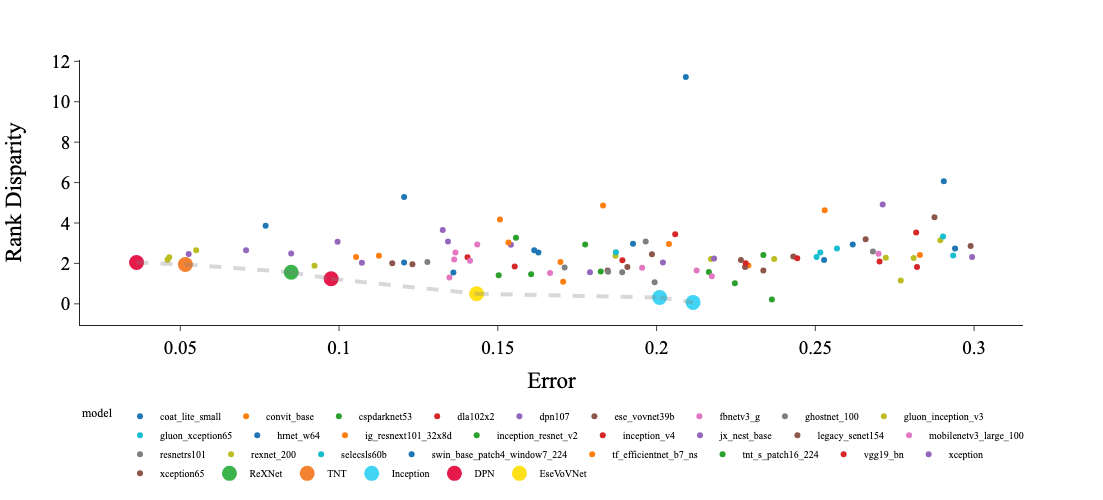

In [51]:
import plotly
df = merge(err_df, rank_df)
df = df[df['epoch'] == 99]
df = df.rename(columns={'Accuracy':'Error'})
df = df.dropna()
df = df[df['Error']<1-1/(7636*2)]
df = df[df['Error']<0.3]
df.loc[:,'model'] = df['index'].apply(lambda x: get_name_details(x)[1])
df = df.sort_values(by=['model'])


fig = px.scatter(df, x='Error', 
                 y='Disparity', 
                 color='model',
                 template="simple_white", 
                 width=1000, height= 500
            )

fig.update_layout(
    yaxis_title="Rank Disparity",
#     yaxis_range=[0,6.15],
#     xaxis_range=[0,.31],
    font=dict(
        family="Times New Roman",
        size=19,
        color="Black"
    )
)
# fig.add_shape(type='line',
#                 x0=0,y0=0,x1=1,y1=0,
#                 line=dict(color='Red',),
#                 xref='x',yref='y'
# )
p = np.array(preparePareto(df[['Error','Disparity']], False, False).dropna())
for x, y in zip(p[:-1], p[1:]):
    fig.add_shape(type='line',
                x0=x[0],y0=x[1],x1=y[0],y1=y[1],
                line=dict(color='gray',width=4),line_dash='dash',
                xref='x',yref='y')
    

fig.update_layout(legend=dict(
    orientation="h",
#     yanchor="bottom",
    y=-.29,
#     xanchor="right",
#     x=.75,
    font=dict(
        family="Times New Roman",
        size=10,
        color="Black"
    )
    )
)

pareto_df = pd.merge(df, pd.DataFrame(p), right_on=[0,1], left_on=["Error","Disparity"])
for model in set(pareto_df['model']):
    # match model name to color
    i = [x.lower()[:3] for x in plotted_models].index(model.lower()[:3])
    name = plotted_models[i]
    color = colors[i]
    fig.add_trace(go.Scatter(
        x=pareto_df[pareto_df['model'] == model]['Error'],
        y=pareto_df[pareto_df['model'] == model]['Disparity'],
        mode='markers',
        name = name,
        marker = dict(color=color,size=15),
    ))

fig.show()
plotly.io.write_image(fig, 'app_RQ1_main_full_coloredmodels.png', format='png')

In [30]:
high_perf_models = df[df['Error']<0.3]['index']

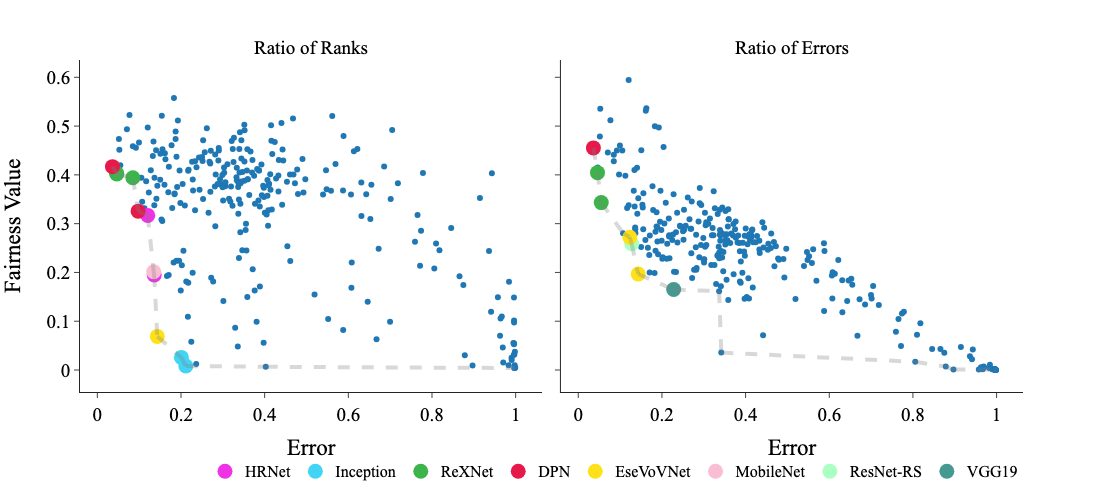

In [59]:
df = merge(err_df, rank_ratio_df)
df = df.rename(columns={'Accuracy':'Error'})
df = merge(df, error_ratio_df)
df = df[df['epoch'] == 99]
df.drop('epoch', axis=1, inplace=True)

df = df.dropna()
df = df[df['Error']<1-1/(7636*2)]
df.loc[:,'model'] = df['index'].apply(lambda x: get_name_details(x)[1].split('_')[0])
df.drop('index', axis=1, inplace=True)
df = df.sort_values(by=['model'])
df = df.rename(columns={'Disparity':'Ratio of Ranks'})
df = df.rename(columns={'Metric':'Ratio of Errors'})
df_non_melt = df
df = df.melt(['model','Error'])


fig = px.scatter(df, x='Error', 
                 y='value', 
                 facet_col='variable',
                 template="simple_white",
                 width=1000, height= 500
            )

fig.update_layout(
    yaxis_title="Fairness Value",
#     yaxis_range=[0,.7],
#     xaxis_range=[0,.31],
    font=dict(
        family="Times New Roman",
        size=19,
        color="Black"
    )
)
# Get Pareto Fronts
p_ratio_ranks = np.array(preparePareto(df_non_melt[['Error','Ratio of Ranks']], False, False).dropna())
pareto_df_ranks = pd.merge(df, pd.DataFrame(p_ratio_ranks), 
                           right_on=[0,1], left_on=["Error","value"])
p_ratio_errors = np.array(preparePareto(df_non_melt[['Error','Ratio of Errors']], False, False).dropna())
pareto_df_error = pd.merge(df, pd.DataFrame(p_ratio_errors), 
                           right_on=[0,1], left_on=["Error","value"])

# # get a list of the models from both sides with error below 0.3
# p_models = list(set(list(set(pareto_df_error[pareto_df_error['Error']<0.3]['model'])) + \
# list(set(pareto_df_ranks[pareto_df_ranks['Error']<0.3]['model']))))
# n_colors = len(p_models)+2
# # turn those models into colors
# colors = px.colors.sample_colorscale("turbo", [n/(n_colors -1) for n in range(n_colors)])
# colors = {x:colors[i] for i, x in enumerate(p_models)}

# plot PFront for Ranks
for x, y in zip(p_ratio_ranks[:-1], p_ratio_ranks[1:]):
    fig.add_shape(type='line',
                x0=x[0],y0=x[1],x1=y[0],y1=y[1],
                line=dict(color='gray',width=4),line_dash='dash',
                xref='x',yref='y', col=1,row=1)
for model in set(pareto_df_ranks['model']):
    if max(pareto_df_ranks[pareto_df_ranks['model'] == model]['Error']) > 0.3:
        continue
    i = [x.lower()[:3] for x in plotted_models].index(model.lower()[:3])
    name = plotted_models[i]
    color = colors[i]
    fig.add_trace(go.Scatter(
        x=pareto_df_ranks[pareto_df_ranks['model'] == model]['Error'],
        y=pareto_df_ranks[pareto_df_ranks['model'] == model]['value'],
        mode='markers',
        name = name,
        marker_color = color,
        marker = dict(size=15),
    ), col=1,row=1)

# plot PFront for Error
for x, y in zip(p_ratio_errors[:-1], p_ratio_errors[1:]):
    fig.add_shape(type='line',
                x0=x[0],y0=x[1],x1=y[0],y1=y[1],
                line=dict(color='gray',width=4),line_dash='dash',
                xref='x',yref='y', col=2,row=1)
for model in set(pareto_df_error['model']):
    if max(pareto_df_error[pareto_df_error['model'] == model]['Error']) > 0.3:
        continue
    i = [x.lower()[:3] for x in plotted_models].index(model.lower()[:3])
    name = plotted_models[i]
    color = colors[i]
    fig.add_trace(go.Scatter(
        x=pareto_df_error[pareto_df_error['model'] == model]['Error'],
        y=pareto_df_error[pareto_df_error['model'] == model]['value'],
        mode='markers',
        name = name,
        marker_color = color,
        marker = dict(size=15),
    ), col=2,row=1)
    
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=-.29,
    xanchor="right",
    x=1,
    font=dict(
        family="Times New Roman",
        size=16,
        color="Black"
    )
    )
)

names = set()
fig.for_each_trace(
    lambda trace:
        trace.update(showlegend=False)
        if (trace.name in names) else names.add(trace.name))


fig.show()
plotly.io.write_image(fig, 'app_ratios_full.png', format='png')

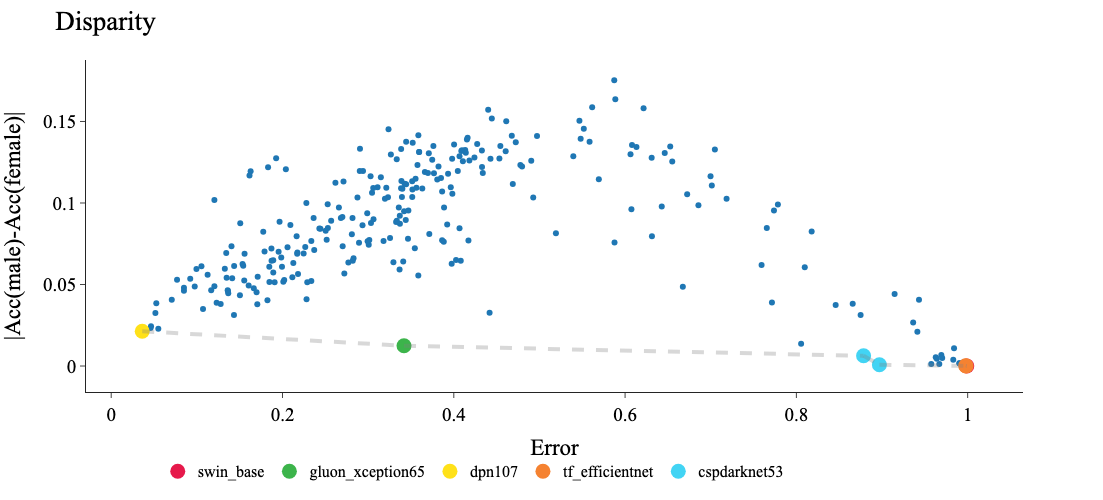

In [63]:
import plotly
df = merge(err_df, acc_disp_df)
df = df[df['epoch'] == 99]
df = df.rename(columns={'Accuracy':'Error'})
df = df.dropna()
df = df[df['Error']<1-1/(7636*2)]
df.loc[:,'model'] = df['index'].apply(lambda x: '_'.join(get_name_details(x)[1].split('_')[:2]))
df = df.sort_values(by=['model'])


fig = px.scatter(df, x='Error', 
                 y='Disparity', 
                 template="simple_white", 
                 width=1000, height= 500
            )

fig.update_layout(
    title = "Disparity",
    yaxis_title="|Acc(male)-Acc(female)|",
#     yaxis_range=[0,6.15],
#     xaxis_range=[0,.31],
    font=dict(
        family="Times New Roman",
        size=19,
        color="Black"
    )
)
fig.add_shape(type='line',
                x0=0,y0=0,x1=1,y1=0,
                line=dict(color='Red',),
                xref='x',yref='y'
)
p = np.array(preparePareto(df[['Error','Disparity']], False, False).dropna())
for x, y in zip(p[:-1], p[1:]):
    fig.add_shape(type='line',
                x0=x[0],y0=x[1],x1=y[0],y1=y[1],
                line=dict(color='gray',width=4),line_dash='dash',
                xref='x',yref='y')
    

pareto_df = pd.merge(df, pd.DataFrame(p), right_on=[0,1], left_on=["Error","Disparity"])
ms = list(set(pareto_df['model']))
for model in set(pareto_df['model']):
    # match model name to color
    i = ms.index(model)
    color = colors[i]
    fig.add_trace(go.Scatter(
        x=pareto_df[pareto_df['model'] == model]['Error'],
        y=pareto_df[pareto_df['model'] == model]['Disparity'],
        mode='markers',
        name = model,
        marker = dict(color=color,size=15),
    ))

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=-.29,
    xanchor="right",
    x=.75,
    font=dict(
        family="Times New Roman",
        size=16,
        color="Black"
    )
    )
)

fig.show()
plotly.io.write_image(fig, 'app_acc_disp_full.png', format='png')

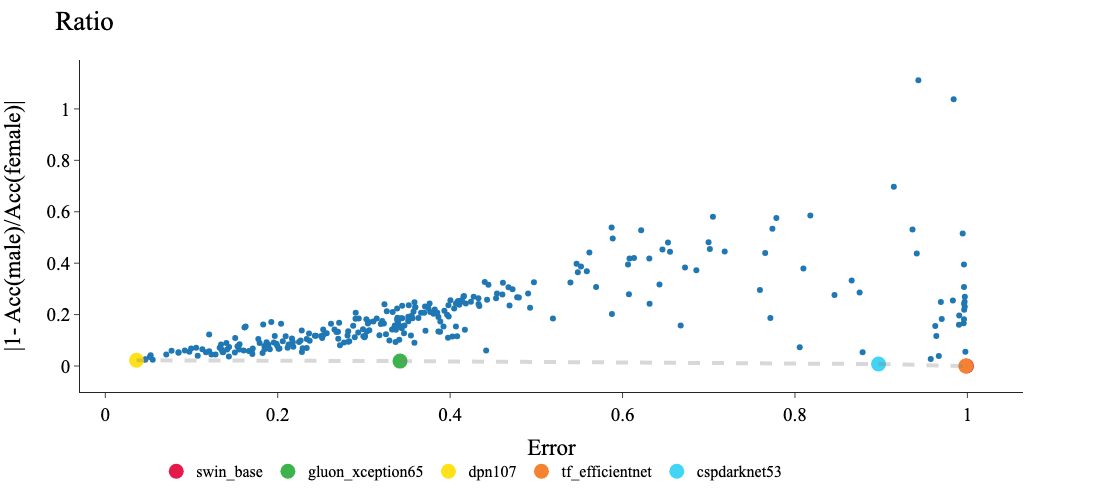

In [62]:
import plotly
df = merge(err_df, acc_disp_ratio_df)
df = df[df['epoch'] == 99]
df = df.rename(columns={'Accuracy':'Error'})
df = df.dropna()
df = df[df['Error']<1-1/(7636*2)]
df.loc[:,'model'] = df['index'].apply(lambda x: '_'.join(get_name_details(x)[1].split('_')[:2]))
df = df.sort_values(by=['model'])


fig = px.scatter(df, x='Error', 
                 y='Disparity', 
                 template="simple_white", 
                 width=1000, height= 500
            )

fig.update_layout(
    title = "Ratio",
    yaxis_title="|1- Acc(male)/Acc(female)|",
#     yaxis_range=[0,6.15],
#     xaxis_range=[0,.31],
    font=dict(
        family="Times New Roman",
        size=19,
        color="Black"
    )
)
fig.add_shape(type='line',
                x0=0,y0=0,x1=1,y1=0,
                line=dict(color='Red',),
                xref='x',yref='y'
)
p = np.array(preparePareto(df[['Error','Disparity']], False, False).dropna())
for x, y in zip(p[:-1], p[1:]):
    fig.add_shape(type='line',
                x0=x[0],y0=x[1],x1=y[0],y1=y[1],
                line=dict(color='gray',width=4),line_dash='dash',
                xref='x',yref='y')
    

pareto_df = pd.merge(df, pd.DataFrame(p), right_on=[0,1], left_on=["Error","Disparity"])
ms = list(set(pareto_df['model']))
for model in set(pareto_df['model']):
    # match model name to color
    i = ms.index(model)
    color = colors[i]
    fig.add_trace(go.Scatter(
        x=pareto_df[pareto_df['model'] == model]['Error'],
        y=pareto_df[pareto_df['model'] == model]['Disparity'],
        mode='markers',
        name = model,
        marker = dict(color=color,size=15),
    ))

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=-.29,
    xanchor="right",
    x=.75,
    font=dict(
        family="Times New Roman",
        size=16,
        color="Black"
    )
    )
)

fig.show()
plotly.io.write_image(fig, 'app_acc_disp_ratio.png', format='png')

# different models different pareto dominant hps

In [54]:
models = get_finished_models_Phase1B()

model1 = 'inception_resnet_v2'
model2 = 'xception65'
rank_files = glob.glob(f'../Checkpoints_scratch/{model1}*/*_rank_by_id_val.csv')
rank_files += glob.glob(f'../Checkpoints_scratch/{model2}*/*_rank_by_id_val.csv')
metadata = pd.read_csv('val_identities_gender-expression_seed_222.csv')

epochs = ['epoch_'+str(i) for i in [19,39,59,79,99]]

accdf_sub, acc_dispdf_sub, rankdf_sub = analyze_rank_files(rank_files, metadata, epochs=epochs)
_, acc_disp_ratiodf_sub, rank_ratiodf_sub = analyze_rank_files(rank_files, metadata, ratio=True, epochs=epochs)
errdf_sub, error_ratiodf_sub, _ = analyze_rank_files(rank_files, metadata, ratio=True, error=True, epochs=epochs)

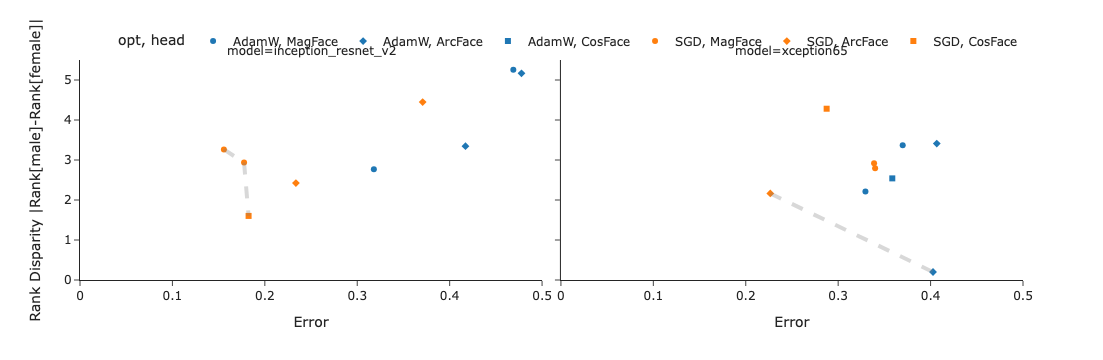

In [55]:
import plotly
df = merge(errdf_sub, rankdf_sub)
df = df[df['epoch'] == 99]
df = df.rename(columns={'Accuracy':'Error'})
df = df.dropna()
df = df[df['Error']<1-1/(7636*2)]
df = df[df['Error']<.6]
df.loc[:,'model'] = df['index'].apply(lambda x: get_name_details(x)[1])
df.loc[:,'head'] = df['index'].apply(lambda x: get_name_details(x)[-2])
df.loc[:,'opt'] = df['index'].apply(lambda x: get_name_details(x)[-1])
df = df.sort_values(by=['model'])


fig = px.scatter(df, x='Error', 
                 y='Disparity', 
                 color='opt',
                 symbol='head',
                 template="simple_white",
                 facet_col = 'model'
            )

fig.update_layout(
    yaxis_title="Rank Disparity |Rank[male]-Rank[female]|",
    yaxis_range=[0,5.5],
    xaxis_range=[0,.5]
)
fig.add_shape(type='line',
                x0=0,y0=0,x1=1,y1=0,
                line=dict(color='Red',),
                xref='x',yref='y'
)
p = np.array(preparePareto(df[df['model'] == model2][['Error','Disparity']], False, False).dropna())
for x, y in zip(p[:-1], p[1:]):
    fig.add_shape(type='line',
                x0=x[0],y0=x[1],x1=y[0],y1=y[1], col=0,row=0,
                line=dict(color='gray',width=4),line_dash='dash',
                xref='x',yref='y')
p = np.array(preparePareto(df[df['model'] == model1][['Error','Disparity']], False, False).dropna())
for x, y in zip(p[:-1], p[1:]):
    fig.add_shape(type='line',
                x0=x[0],y0=x[1],x1=y[0],y1=y[1], col=1,row=0,
                line=dict(color='gray',width=4),line_dash='dash',
                xref='x',yref='y')
    

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

fig.show()
plotly.io.write_image(fig, 'app_pareto_diff.pdf', format='pdf')

# transfer

## RFW

In [16]:
import pandas as pd
import numpy as np
import os
from analysis import *
import glob
import plotly.io as pio
pio.renderers.default = 'notebook'
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [17]:
metadata = pd.read_csv('RFW_test_identities_ethnicity.csv')
AfAs = metadata[np.logical_or(metadata.ethnicity == 'African', metadata.ethnicity == 'Asian')]
AfAs['gender_expression'] = AfAs.ethnicity.map(lambda x: 'male' if x == 'African' else 'female' )
AfAs.to_csv('RFW_AfAs_test_identities_ethnicity.csv')
AfCa = metadata[np.logical_or(metadata.ethnicity == 'African', metadata.ethnicity == 'Caucasian')]
AfCa['gender_expression'] = AfCa.ethnicity.map(lambda x: 'male' if x == 'African' else 'female' )
AfCa.to_csv('RFW_AfCa_test_identities_ethnicity.csv')
AfIn = metadata[np.logical_or(metadata.ethnicity == 'African', metadata.ethnicity == 'Indian')]
AfIn['gender_expression'] = AfIn.ethnicity.map(lambda x: 'male' if x == 'African' else 'female' )
AfIn.to_csv('RFW_AfIn_test_identities_ethnicity.csv')
AsCa = metadata[np.logical_or(metadata.ethnicity == 'Asian', metadata.ethnicity == 'Caucasian')]
AsCa['gender_expression'] = AsCa.ethnicity.map(lambda x: 'male' if x == 'Asian' else 'female' )
AsCa.to_csv('RFW_AsCa_test_identities_ethnicity.csv')
AsIn = metadata[np.logical_or(metadata.ethnicity == 'Asian', metadata.ethnicity == 'Indian')]
AsIn['gender_expression'] = AsIn.ethnicity.map(lambda x: 'male' if x == 'Asian' else 'female' )
AsIn.to_csv('RFW_AsIn_test_identities_ethnicity.csv')
CaIn = metadata[np.logical_or(metadata.ethnicity == 'Caucasian', metadata.ethnicity == 'Indian')]
CaIn['gender_expression'] = CaIn.ethnicity.map(lambda x: 'male' if x == 'Caucasian' else 'female' )
CaIn.to_csv('RFW_CaIn_test_identities_ethnicity.csv')

In [24]:
import pandas as pd
import numpy as np
import os
from analysis import *
import glob
rank_files = glob.glob('RFW/**/*_rank_by_id_val.csv')

In [25]:
acc_list_rfw, acc_disp_list_rfw, rank_list_rfw, acc_disp_ratio_list_rfw, rank_ratio_list_rfw, err_list_rfw, error_ratio_list_rfw = [],[],[],[],[],[],[]

for a in ['AfAs', 'AfCa', 'AfIn', 'AsCa', 'AsIn', 'CaIn']:
    metadata = pd.read_csv(f'RFW_{a}_test_identities_ethnicity.csv')

    epochs = ['epoch_'+str(i) for i in [99]]
    acc_df_rfw, acc_disp_df_rfw, rank_df_rfw = analyze_rank_files(rank_files, metadata, epochs=epochs)
    _, acc_disp_ratio_df_rfw, rank_ratio_df_rfw = analyze_rank_files(rank_files, metadata, ratio=True, epochs=epochs)
    err_df_rfw, error_ratio_df_rfw, _ = analyze_rank_files(rank_files, metadata, ratio=True, error=True, epochs=epochs)
    acc_list_rfw += [acc_df_rfw]
    acc_disp_list_rfw += [acc_disp_df_rfw]
    rank_list_rfw += [rank_df_rfw]
    acc_disp_ratio_list_rfw += [acc_disp_ratio_df_rfw]
    rank_ratio_list_rfw += [rank_ratio_df_rfw]
    err_list_rfw += [err_df_rfw]
    error_ratio_list_rfw += [error_ratio_df_rfw]

In [26]:
from functools import reduce

def reduce_list_rfw(l, f=max):
    df = reduce(lambda x, y: pd.merge(x, y, on = ['index','epoch']), l)

    df['Metric'] = df.loc[:,df.columns.str.startswith('Metric')].apply(lambda x: f(x), axis=1)
    df=df.loc[:,np.logical_not(df.columns.str.startswith('Metric_'))]
    return df

acc_df_rfw = reduce_list_rfw(acc_list_rfw, f=np.mean)
acc_disp_df_rfw = reduce_list_rfw(acc_disp_list_rfw)
rank_df_rfw = reduce_list_rfw(rank_list_rfw)
acc_disp_ratio_df_rfw = reduce_list_rfw(acc_disp_ratio_list_rfw)
rank_ratio_list_rfw = reduce_list_rfw(rank_ratio_list_rfw)
err_df_rfw = reduce_list_rfw(err_list_rfw)
error_ratio_df_rfw = reduce_list_rfw(error_ratio_list_rfw)

/tmp/ipykernel_3567158/2886830550.py:4: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'Metric_x'} in the result is deprecated and will raise a MergeError in a future version.



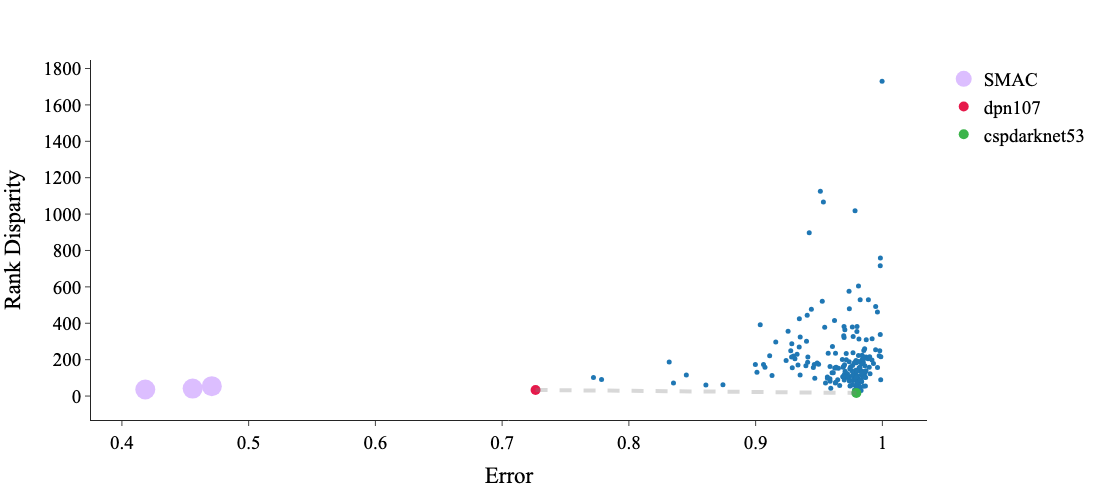

In [44]:
df = merge(err_df_rfw, rank_df_rfw)
df = df[df['epoch'] == 99]
df = df.rename(columns={'Accuracy':'Error','Disparity':'Rank Disparity'})
df = df.dropna()
df = df[df['Error']<1-1/(7636*2)]
# df.loc[:,'model'] = df['index'].apply(lambda x: get_name_details(x)[1])
df = df.sort_values(by=['index'])
# remove 040
df = df[df['index'].apply(lambda x: '040' not in x)]
df_high_perf = df
df_high_perf.loc[:,'Model'] = 'timm models'
# df['Disparity'] = np.log(df['Disparity'])
fig = px.scatter(data_frame = df_high_perf
           ,x = 'Error'
           ,y = 'Rank Disparity',
#             color='Model',
             template="simple_white",
                 width=1000, height= 500
           )
fig.update_traces(marker=dict(size=5))

fig.add_trace(go.Scatter(
    x=df[df['index'].apply(lambda x: 'Check' in x)]['Error'],
    y=df[df['index'].apply(lambda x: 'Check' in x)]['Rank Disparity'],
    mode='markers',
    name = 'SMAC',
    marker_color = colors[-1],
    marker = dict(size=20),
))
# plot PFront
p = np.array(preparePareto(df[df['index'].apply(lambda x: 'Check' not in x)][['Error','Rank Disparity']], 
                           False, False).dropna())
for x, y in zip(p[:-1], p[1:]):
    fig.add_shape(type='line',
                x0=x[0],y0=x[1],x1=y[0],y1=y[1],
                line=dict(color='gray',width=4),line_dash='dash',
                xref='x',yref='y', col=1,row=1)
    
fig.update_layout(
#     xaxis_range=[.35,max(df_high_perf['Error'])],
#     yaxis_range=[0,500],
    font=dict(
        family="Times New Roman",
        size=19,
        color="Black"
    )
)


pareto_df = pd.merge(df_high_perf, pd.DataFrame(p), 
                           right_on=[0,1], left_on=["Error","Rank Disparity"])
pareto_df.loc[:,'model'] = pareto_df['index'].apply(lambda x: get_name_details(x)[1].split('_')[0])
pareto_df = pareto_df[pareto_df['Error']<1]

# plot PFront for Ranks
ms = list(set(pareto_df['model']))
for model in set(pareto_df['model']):
    # match model name to color
    i = ms.index(model) % len(colors)
    color = colors[i]
    fig.add_trace(go.Scatter(
        x=pareto_df[pareto_df['model'] == model]['Error'],
        y=pareto_df[pareto_df['model'] == model]['Rank Disparity'],
        mode='markers',
        name = model,
        marker_color = color,
        marker = dict(size=10),
    ))

# fig.update_layout(showlegend=False)
fig.show()
plotly.io.write_image(fig, 'app__rfw.png', format='png')

## VGGFace2

In [29]:
rank_files = glob.glob('vggface2_train/**/C*_rank_by_id_val.csv')
rank_files = rank_files + glob.glob('vggface2_train/**/fa*_rank_by_id_val.csv')
metadata = pd.read_csv('vggface2_test_identities_gender.csv')

epochs = ['epoch_'+str(i) for i in [5]]

acc_df_vgg, acc_disp_df_vgg, rank_df_vgg = analyze_rank_files(rank_files, metadata, epochs=epochs)
_, acc_disp_ratio_df_vgg, rank_ratio_df_vgg = analyze_rank_files(rank_files, metadata, ratio=True, epochs=epochs)
err_df_vgg, error_ratio_df_vgg, _ = analyze_rank_files(rank_files, metadata, ratio=True, error=True, epochs=epochs)

In [30]:
def _get_name_details(x):
    if 'Check' in x:
        return 'SMAC'
    else:
        return get_name_details(x)[1].split('_')[0]

In [31]:
acc_df_vgg

,index,epoch,Metric
0,Checkpoints_Edges_000_LR_0.2813375341651194_He...,5,0.952970
1,Checkpoints_Edges_680_LR_0.0006048015915653069...,5,0.971122
2,Checkpoints_Edges_010_LR_0.32348738788346576_H...,5,0.932343
3,faceevoLVe_ArcFace_rank_by_id_val,5,0.775578


In [33]:
df = merge(err_df_vgg, rank_df_vgg)
# df = df[df['epoch'] == 2]
df = df.rename(columns={'Accuracy':'Error','Disparity':'Rank Disparity'})
df = df.dropna()
df = df[df['Error']<1-1/(7636*2)]
df
print(df[['index','Error','Rank Disparity']].to_latex(index=False))

\begin{tabular}{lrr}
\toprule
                                             index &    Error &  Rank Disparity \\
\midrule
Checkpoints\_Edges\_000\_LR\_0.2813375341651194\_Hea... & 0.047030 &        0.863036 \\
Checkpoints\_Edges\_680\_LR\_0.0006048015915653069\_... & 0.028878 &        1.536304 \\
Checkpoints\_Edges\_010\_LR\_0.32348738788346576\_He... & 0.067657 &        0.760726 \\
                 faceevoLVe\_ArcFace\_rank\_by\_id\_val & 0.224422 &       10.077558 \\
\bottomrule
\end{tabular}



In [12]:
df = merge(err_df_vgg, rank_df_vgg)
# df = df[df['epoch'] == 2]
df = df.rename(columns={'Accuracy':'Error','Disparity':'Rank Disparity'})
df = df.dropna()
df = df[df['Error']<1-1/(7636*2)]
# df.loc[:,'model'] = df['index'].apply(lambda x: get_name_details(x)[1])
df = df.sort_values(by=['index'])
df = df.drop([0,30,24,6,18, 22,16,34,4,10, 13,31,7,19,1, 15,9,8,14,], axis=0)
# remove 040
df = df[df['index'].apply(lambda x: '040' not in x)]
df_high_perf = df
df_high_perf.loc[:,'Model'] = 'timm models'
# df['Disparity'] = np.log(df['Disparity'])
fig = px.scatter(data_frame = df_high_perf
           ,x = 'Error'
           ,y = 'Rank Disparity',
#             color='Model',
             template="simple_white",
                 width=1000, height= 500
           )
fig.update_traces(marker=dict(size=5))

# fig.add_trace(go.Scatter(
#     x=df[df['index'].apply(lambda x: 'Check' in x)]['Error'],
#     y=df[df['index'].apply(lambda x: 'Check' in x)]['Rank Disparity'],
#     mode='markers',
#     name = 'SMAC',
#     marker_color = colors[-1],
#     marker = dict(size=20),
# ))
# plot PFront
p = np.array(preparePareto(df[['Error','Rank Disparity']], 
                           False, False).dropna())
for x, y in zip(p[:-1], p[1:]):
    fig.add_shape(type='line',
                x0=x[0],y0=x[1],x1=y[0],y1=y[1],
                line=dict(color='gray',width=4),line_dash='dash',
                xref='x',yref='y', col=1,row=1)
    
fig.update_layout(
#     xaxis_range=[.35,max(df_high_perf['Error'])],
#     yaxis_range=[0,500],
    font=dict(
        family="Times New Roman",
        size=19,
        color="Black"
    )
)


# pareto_df = pd.merge(df_high_perf, pd.DataFrame(p), 
#                            right_on=[0,1], left_on=["Error","Rank Disparity"])
df.loc[:,'model'] = df['index'].apply(lambda x: _get_name_details(x))
# pareto_df = pareto_df[pareto_df['Error']<1]

# plot PFront for Ranks
ms = list(set(df['model']))
for model in set(df['model']):
    # match model name to color
    i = ms.index(model) % len(colors)
    color = colors[i]
    fig.add_trace(go.Scatter(
        x=df[df['model'] == model]['Error'],
        y=df[df['model'] == model]['Rank Disparity'],
        mode='markers',
        name = model,
        marker_color = color,
        marker = dict(size=10),
    ))

# fig.update_layout(showlegend=False)
fig.show()
# plotly.io.write_image(fig, 'app__vgg.png', format='png')

KeyError: '[30 24  6 18 22 16 34  4 10 13 31  7 19 15  9  8 14] not found in axis'

In [48]:
df

,index,epoch,Error,Rank Disparity,Model,model
12,Checkpoints_Edges_000_LR_0.2813375341651194_He...,2,0.042904,0.813531,timm models,SMAC
28,Checkpoints_Edges_010_LR_0.32348738788346576_H...,4,0.059406,0.853135,timm models,SMAC
25,Checkpoints_Edges_680_LR_0.0006048015915653069...,4,0.034653,2.334983,timm models,SMAC
3,dpn107_CosFace_SGD_0.1_cosine_rank_by_id_val,0,0.099010,1.318482,timm models,dpn107
2,dpn107_MagFace_SGD_0.1_cosine_rank_by_id_val,0,0.069307,0.531353,timm models,dpn107
5,rexnet_200_MagFace_SGD_0.1_cosine_rank_by_id_val,0,0.075908,0.706271,timm models,rexnet


In [39]:
df

,index,epoch,Error,Rank Disparity,Model
12,Checkpoints_Edges_000_LR_0.2813375341651194_He...,2,0.042904,0.813531,timm models
28,Checkpoints_Edges_010_LR_0.32348738788346576_H...,4,0.059406,0.853135,timm models
25,Checkpoints_Edges_680_LR_0.0006048015915653069...,4,0.034653,2.334983,timm models
3,dpn107_CosFace_SGD_0.1_cosine_rank_by_id_val,0,0.099010,1.318482,timm models
5,rexnet_200_MagFace_SGD_0.1_cosine_rank_by_id_val,0,0.075908,0.706271,timm models


In [13]:
fig = px.scatter(data_frame = df_high_perf
           ,x = 'Error'
           ,y = 'Rank Disparity',
#             color='Model',
             template="simple_white",
                 width=1000, height= 500
           )
fig.show()